# Section 4: Hands-On Data Analysis Lab &ndash; Asynchronous Session

We will practice all that you’ve learned in a hands-on lab. Sample solutions to the lab tasks for the asynchronous session can be found below. 

### About the Data

We will be using 2019 flight statistics from the United States Department of Transportation’s Bureau of Transportation Statistics (available [here](https://www.transtats.bts.gov/DL_SelectFields.asp?gnoyr_VQ=FMF&QO_fu146_anzr=Nv4%20Pn44vr45) and in this repository as `data/T100_MARKET_ALL_CARRIER.zip`). Each row contains information about a specific route for a given carrier in a given month (e.g., JFK &rarr; LAX on Delta Airlines in January). There are 321,409 rows and 41 columns. Note that you don't need to unzip the file to read it in with `pd.read_csv()`.

### Solutions

##### 1. Read in the data and convert the column names to lowercase to make them easier to work with.

In [1]:
import pandas as pd

df = pd.read_csv('../data/T100_MARKET_ALL_CARRIER.zip').rename(lambda x: x.lower(), axis=1)
df.head()

,passengers,freight,mail,distance,unique_carrier,airline_id,unique_carrier_name,unique_carrier_entity,region,carrier,...,dest_state_nm,dest_country,dest_country_name,dest_wac,year,quarter,month,distance_group,class,data_source
0,0.0,53185.0,0.0,8165.0,EK,20392,Emirates,9678A,I,EK,...,Texas,US,United States,74,2019,1,3,17,G,IF
1,0.0,9002.0,0.0,6849.0,EK,20392,Emirates,9678A,I,EK,...,New York,US,United States,22,2019,1,3,14,G,IF
2,0.0,2220750.0,0.0,7247.0,EK,20392,Emirates,9678A,I,EK,...,Illinois,US,United States,41,2019,1,3,15,G,IF
3,0.0,1201490.0,0.0,8165.0,EK,20392,Emirates,9678A,I,EK,...,NaN,AE,United Arab Emirates,678,2019,1,3,17,G,IF
4,0.0,248642.0,0.0,6849.0,EK,20392,Emirates,9678A,I,EK,...,NaN,AE,United Arab Emirates,678,2019,1,3,14,G,IF


##### 2. What columns are in the data?

In [2]:
df.columns

Index(['passengers', 'freight', 'mail', 'distance', 'unique_carrier',
       'airline_id', 'unique_carrier_name', 'unique_carrier_entity', 'region',
       'carrier', 'carrier_name', 'carrier_group', 'carrier_group_new',
       'origin_airport_id', 'origin_airport_seq_id', 'origin_city_market_id',
       'origin', 'origin_city_name', 'origin_state_abr', 'origin_state_fips',
       'origin_state_nm', 'origin_country', 'origin_country_name',
       'origin_wac', 'dest_airport_id', 'dest_airport_seq_id',
       'dest_city_market_id', 'dest', 'dest_city_name', 'dest_state_abr',
       'dest_state_fips', 'dest_state_nm', 'dest_country', 'dest_country_name',
       'dest_wac', 'year', 'quarter', 'month', 'distance_group', 'class',
       'data_source'],
      dtype='object')

##### 3. How many distinct carrier names are in the dataset?

In [3]:
df.unique_carrier_name.nunique()

318

##### 4. Calculate the totals of the `freight`, `mail`, and `passengers` columns for flights from the United Kingdom to the United States.

In [4]:
df.query(
    'origin_country_name == "United Kingdom" and dest_country_name == "United States"'
)[['freight', 'mail', 'passengers']].sum()

freight       903296879.0
mail           29838395.0
passengers     10685608.0
dtype: float64

##### 5. Find the top 5 carriers for median route distance (i.e., for all origin-destination pairs that each carrier has, find the median distance after removing duplicates).

In [5]:
df[['unique_carrier_name', 'origin', 'dest', 'distance']].drop_duplicates()\
    .groupby('unique_carrier_name').distance.median().nlargest(5)

unique_carrier_name
Singapore Airlines Ltd.                                       8068.0
Cathay Pacific Airways Ltd.                                   8020.0
Qantas Airways Ltd.                                           7886.0
Longtail Aviation Ltd.                                        7855.5
National Aviation Company of India Limited d/b/a Air India    7798.0
Name: distance, dtype: float64

##### 6. Find the total cargo transported (mail + freight) and mean distance traveled for the 10 carriers that transported the most cargo.

In [6]:
df.assign(cargo=lambda x: x.mail + x.freight)\
    .groupby('unique_carrier_name')[['cargo', 'distance']]\
    .agg(dict(cargo='sum', distance='mean')).nlargest(10, 'cargo')

,cargo,distance
unique_carrier_name,,
Federal Express Corporation,1.270966e+10,1121.887981
United Parcel Service,9.173867e+09,1030.812650
Atlas Air Inc.,3.356847e+09,1900.987202
United Air Lines Inc.,1.577892e+09,1810.656058
American Airlines Inc.,1.353074e+09,1583.185048
Kalitta Air LLC,1.272180e+09,2519.580343
Polar Air Cargo Airways,1.199386e+09,3111.794118
Delta Air Lines Inc.,1.129524e+09,1612.688752
China Airlines Ltd.,8.370799e+08,5828.277778


##### 7. Which 10 carriers flew the most passengers out of the United States to another country?

In [7]:
top_10_by_passengers = df\
    .query('origin_country_name == "United States" and dest_country_name != "United States"')\
    .groupby('unique_carrier_name').passengers.sum().nlargest(10)
top_10_by_passengers

unique_carrier_name
American Airlines Inc.       14867653.0
United Air Lines Inc.        14427923.0
Delta Air Lines Inc.         13054230.0
JetBlue Airways               4522492.0
British Airways Plc           3758945.0
Lufthansa German Airlines     3123611.0
Westjet                       2626600.0
Air Canada                    2540855.0
Southwest Airlines Co.        2146960.0
Virgin Atlantic Airways       2074735.0
Name: passengers, dtype: float64

##### 8. For each of the carriers found in *#7*, find the most popular destination country outside of the United States.

In [8]:
df.query('origin_country_name == "United States" and dest_country_name != "United States"')\
    .groupby(['unique_carrier_name', 'dest_country_name']).passengers.sum()\
    .groupby(level=0, group_keys=False).nlargest(1)[top_10_by_passengers.index]

unique_carrier_name        dest_country_name 
American Airlines Inc.     Mexico                2424606.0
United Air Lines Inc.      Mexico                2201389.0
Delta Air Lines Inc.       Mexico                1872840.0
JetBlue Airways            Dominican Republic    1413023.0
British Airways Plc        United Kingdom        3758945.0
Lufthansa German Airlines  Germany               3123209.0
Westjet                    Canada                2626600.0
Air Canada                 Canada                2540855.0
Southwest Airlines Co.     Mexico                1001375.0
Virgin Atlantic Airways    United Kingdom        2074735.0
Name: passengers, dtype: float64

##### 9. For each of the carriers found in *#7*, find the total number of passengers flown on international flights to/from the destinations in *#8* or the United States. Note that this dataset only has data for flights with an origin and/or destination of the United States.

In [9]:
df.query(
    'origin_country_name.isin(["Canada", "Dominican Republic", "Germany", "Mexico", "United Kingdom", "United States"])'
    ' and dest_country_name.isin(["Canada", "Dominican Republic", "Germany", "Mexico", "United Kingdom", "United States"])'
    f' and dest_country_name != origin_country_name and unique_carrier_name.isin({top_10_by_passengers.index.to_list()})'
).groupby('unique_carrier_name').passengers.sum().sort_values(ascending=False)

unique_carrier_name
United Air Lines Inc.        12237405.0
American Airlines Inc.       11091254.0
Delta Air Lines Inc.          8914478.0
British Airways Plc           7531344.0
Lufthansa German Airlines     6298202.0
Westjet                       5273827.0
Air Canada                    5044089.0
Virgin Atlantic Airways       4140090.0
JetBlue Airways               3770798.0
Southwest Airlines Co.        2284341.0
Name: passengers, dtype: float64

##### 10. Between which two cities were the most passengers flown? Make sure to account for both directions.

In [10]:
top_route = df.sort_values(['origin_city_name', 'dest_city_name']).assign(
    route=lambda x: 
        x[['origin_city_name', 'dest_city_name']].min(axis=1) \
        + '-' \
        + x[['origin_city_name', 'dest_city_name']].max(axis=1)
).groupby('route').passengers.sum().nlargest(1)
top_route

route
Chicago, IL-New York, NY    4131579.0
Name: passengers, dtype: float64

##### 11. Find the top 3 carriers for the pair of cities found in *#10* and calculate the percentage of passengers each accounted for.

In [11]:
top_3 = df.sort_values(['origin_city_name', 'dest_city_name']).assign(
    route=lambda x: 
        x[['origin_city_name', 'dest_city_name']].min(axis=1) \
        + '-' \
        + x[['origin_city_name', 'dest_city_name']].max(axis=1)
).query(
    'route == "Chicago, IL-New York, NY"'
).groupby('unique_carrier_name').passengers.sum().div(top_route.iloc[0]).nlargest(3)
top_3

unique_carrier_name
American Airlines Inc.    0.313051
United Air Lines Inc.     0.232274
Delta Air Lines Inc.      0.133334
Name: passengers, dtype: float64

##### 12. Find the percentage of international travel per country using total passengers on class F flights.

In [12]:
import numpy as np

international_passenger_travel = df.query(
    'origin_country_name != dest_country_name and `class` == "F"'
).assign(
    international_country=lambda x: np.where(x.origin_country_name != 'United States', x.origin_country_name, x.dest_country_name)
).groupby('international_country').passengers.sum()

international_travel_pct = (international_passenger_travel / international_passenger_travel.sum()).nlargest(5)
international_travel_pct

international_country
Canada            0.131590
Mexico            0.127295
United Kingdom    0.088743
Germany           0.045096
Japan             0.041461
Name: passengers, dtype: float64

##### 13. Using a crosstab, find the percentage of total passengers on class F international flights between US cities and the countries found in *#12* that used the carriers found in *#11*. 

In [13]:
international_travel = df.query(
    'origin_country_name != dest_country_name and `class` == "F"'
).assign(
    us_city=lambda x: np.where(x.origin_country_name == 'United States', x.origin_city_name, x.dest_city_name),
    international_country=lambda x: np.where(x.origin_country_name != 'United States', x.origin_country_name, x.dest_country_name)
)

pd.crosstab(
    index=international_travel.unique_carrier_name, columns=international_travel.international_country, 
    values=international_travel.passengers, aggfunc='sum', normalize='index'
).loc[top_3.index, international_travel_pct.index]

international_country,Canada,Mexico,United Kingdom,Germany,Japan
unique_carrier_name,,,,,
American Airlines Inc.,0.036028,0.162185,0.112027,0.016612,0.024537
United Air Lines Inc.,0.079888,0.152699,0.085046,0.077082,0.082790
Delta Air Lines Inc.,0.059044,0.143440,0.052836,0.035196,0.061896


##### 14. Create a pivot table showing the total passengers transported between cities in the United States and other countries by the carriers identified in *#7*. Select the top 10 US cities and top 10 international countries from the result.

In [14]:
df.query(
    f'origin_country_name != dest_country_name and unique_carrier_name.isin({top_10_by_passengers.index.to_list()})'
).assign(
    us_city=lambda x: np.where(x.origin_country_name == 'United States', x.origin_city_name, x.dest_city_name),
    international_country=lambda x: np.where(x.origin_country_name != 'United States', x.origin_country_name, x.dest_country_name)
).pivot_table(
    index='us_city', columns='international_country', 
    values='passengers', aggfunc='sum', margins=True
).sort_values('All', ascending=False, axis=1).drop('All').sort_values('All', ascending=False).drop(columns='All').iloc[:10,:10]

international_country,United Kingdom,Mexico,Canada,Germany,Dominican Republic,Japan,Jamaica,Netherlands,France,China
us_city,,,,,,,,,,
"New York, NY",3599328.0,860173.0,1566104.0,853674.0,2443025.0,3832.0,740717.0,323223.0,471080.0,NaN
"Miami, FL",1037798.0,854086.0,412699.0,375279.0,916565.0,NaN,540691.0,NaN,169557.0,NaN
"Atlanta, GA",773873.0,1569084.0,741236.0,659374.0,462258.0,191342.0,502099.0,499415.0,354917.0,165246.0
"Newark, NJ",1240972.0,633896.0,332936.0,881199.0,868299.0,210033.0,145932.0,151797.0,218570.0,331812.0
"Los Angeles, CA",1385302.0,1327190.0,2286098.0,646628.0,NaN,691868.0,21.0,85930.0,131043.0,644707.0
"Houston, TX",494729.0,2136212.0,822001.0,546553.0,49424.0,165168.0,121717.0,155192.0,277.0,103.0
"San Francisco, CA",1052684.0,584699.0,1597143.0,963039.0,NaN,481210.0,NaN,88737.0,155541.0,513823.0
"Chicago, IL",1263991.0,1091008.0,984908.0,1080619.0,163593.0,206955.0,170676.0,119457.0,242553.0,324351.0
"Dallas/Fort Worth, TX",751539.0,2047306.0,446766.0,359896.0,17801.0,327051.0,88858.0,67102.0,211081.0,311610.0


##### 15: For the top 15 international countries, find the percentage of class F passengers traveling to/from the top 10 US cities for international travel (e.g. if only cities A, B, and C flew into Aruba, the sum of the Aruba row/column would be 1). Plot the result as a heatmap.

In [15]:
international_travel = df.query(
    'origin_country_name != dest_country_name and `class` == "F"'
).assign(
    us_city=lambda x: np.where(x.origin_country_name == 'United States', x.origin_city_name, x.dest_city_name),
    international_country=lambda x: np.where(x.origin_country_name != 'United States', x.origin_country_name, x.dest_country_name)
)

international_travel_pivot = international_travel.pivot_table(
    index='us_city', columns='international_country', 
    values='passengers', aggfunc='sum', margins=True
).sort_values('All', ascending=False, axis=1).sort_values('All', ascending=False)

normalized_international_travel = (international_travel_pivot / international_travel_pivot.loc['All']).drop('All').drop(columns='All')
pct_of_passengers_country = normalized_international_travel.iloc[:10,:15].sort_index().sort_index(axis=1)
pct_of_passengers_country

international_country,Brazil,Canada,China,Colombia,Dominican Republic,France,Germany,Italy,Jamaica,Japan,Mexico,Netherlands,South Korea,Spain,United Kingdom
us_city,,,,,,,,,,,,,,,
"Atlanta, GA",0.073838,0.035586,0.019355,0.037853,0.060782,0.097139,0.060561,0.075241,0.113234,0.019115,0.053810,0.127279,0.072975,0.045759,0.036119
"Chicago, IL",0.037089,0.071433,0.063844,0.002887,0.032785,0.041849,0.099252,0.060731,0.038491,0.058029,0.084269,0.045159,0.044433,0.062365,0.063544
"Dallas/Fort Worth, TX",0.041950,0.026075,0.036498,0.019071,0.004950,0.028932,0.033055,0.021876,0.021488,0.045049,0.106572,0.010794,0.049176,0.046921,0.035076
"Houston, TX",0.059782,0.033252,0.017368,0.045179,0.006499,0.017999,0.050199,NaN,0.027450,0.031631,0.123727,0.052429,NaN,0.000032,0.026207
"Los Angeles, CA",0.023076,0.076913,0.286910,0.038416,NaN,0.109862,0.059391,0.053102,0.000005,0.147621,0.135882,0.061764,0.169367,0.071927,0.086234
"Miami, FL",0.329531,0.027053,NaN,0.384063,0.133078,0.055107,0.042238,0.089394,0.121937,NaN,0.045671,0.009405,NaN,0.177602,0.055089
"New York, NY",0.144254,0.086144,0.149604,0.133794,0.321232,0.218849,0.100960,0.382520,0.201859,0.052510,0.058411,0.161742,0.114979,0.291584,0.197837
"Newark, NJ",0.039711,0.053321,0.055757,0.023848,0.124638,0.046894,0.092265,0.127747,0.032911,0.020982,0.021219,0.024417,NaN,0.099181,0.057931
"San Francisco, CA",NaN,0.058750,0.143582,NaN,NaN,0.068619,0.088452,0.008179,NaN,0.076651,0.041180,0.064038,0.118836,0.022546,0.055909


[Text(0.5, 1.0, 'Percentage of travel to/from foreign countries via the top 10 US cities for international passenger travel.'),
 Text(0.5, 58.7222222222222, 'International country'),
 Text(145.72222222222223, 0.5, 'US city')]

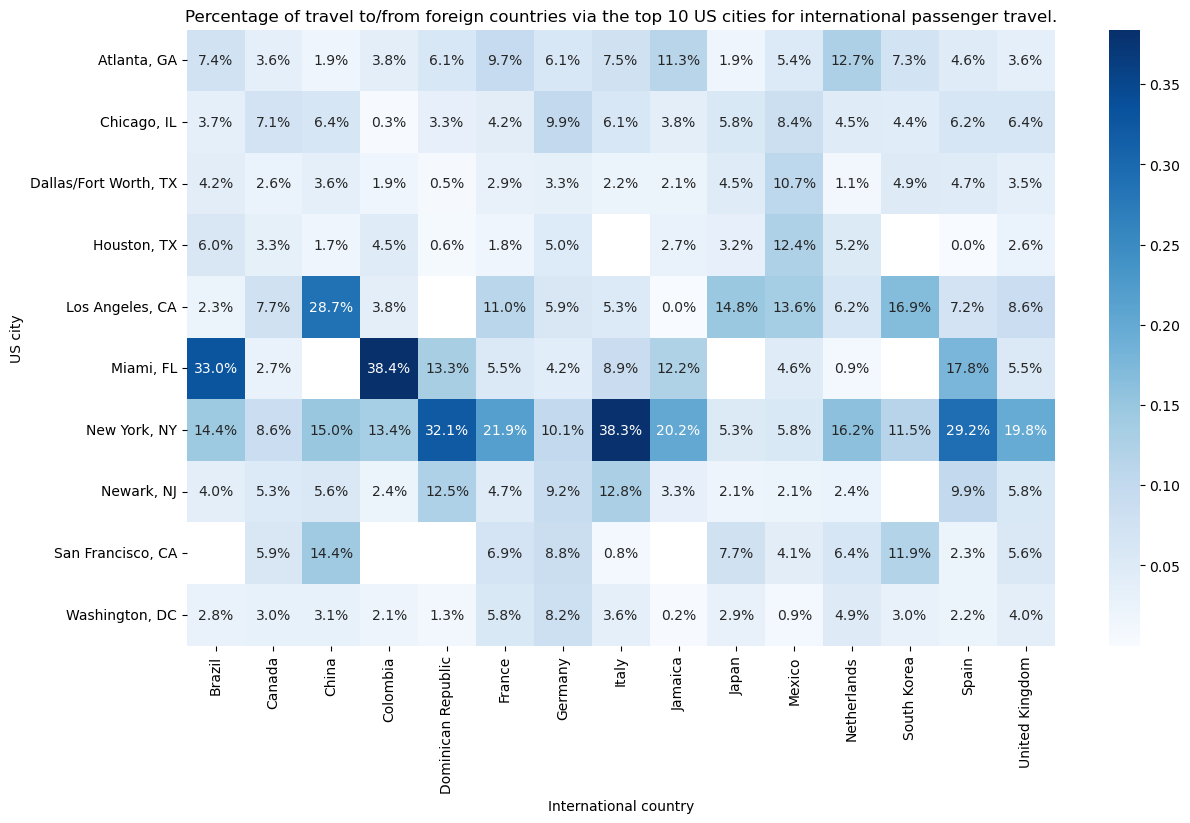

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(14, 8))

sns.heatmap(pct_of_passengers_country, cmap='Blues', annot=True, fmt='.1%', ax=axes)
axes.set(
    title='Percentage of travel to/from foreign countries via the top 10 US cities for international passenger travel.',
    xlabel='International country', ylabel='US city'
)

*Be sure to consult [this](https://medium.com/@stefaniemolin/how-to-pivot-and-plot-data-with-pandas-9450939fcf8) blog post for additional examples of creating pivot tables using this dataset.*